## This notebook can be used to rank a list of nodes from a category that connect to an entity such as a gene. 
#### Example 1: Which disease are associate with NPM1 gene?
#### Example 2: Which proteins interacts with protein NPM1?
#### Example 3: Which drugs or small molecules can interact with NPM1?


In [1]:
import sys
sys.path.append('../src')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Step1: List all the APIs in the translator system
APInames = TCT.list_Translator_APIs()
APInames_current = TCT.get_Translator_APIs()
#set(APInames_current)-set(APInames)


In [3]:
# Step 2: Get metaKG and all predicates from Translator APIs
metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs
print(metaKG.columns)
print(metaKG.shape)

#metaKG.to_csv('../metaData/metaKG.csv', index=False)
#metaKG = pd.read_csv('../metaData/metaKG.csv')
All_predicates = list(set(metaKG['KG_category']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))

Index(['API', 'KG_category', 'Subject', 'Object', 'URL'], dtype='object')
(13559, 5)


In [4]:
# Step 3: set input parameters
# Test multiomics BigGIM Drug Response KP
# Node1 for query
input_node1 = 'NPM1'
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
#input_node2_category = ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']
input_node2_category = ['biolink:Gene']

# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))
print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

NCBIGene:4869
all relevant predicates in Translator:
['biolink:contributes_to', 'biolink:derives_from', 'biolink:causes', 'biolink:regulates', 'biolink:biomarker_for', 'biolink:homologous_to', 'biolink:interacts_with', 'biolink:affects', 'biolink:negatively_correlated_with', 'biolink:close_match', 'biolink:orthologous_to', 'biolink:subclass_of', 'biolink:binds', 'biolink:regulated_by', 'biolink:physically_interacts_with', 'biolink:coexpressed_with', 'biolink:genetic_association', 'biolink:coexists_with', 'biolink:produced_by', 'biolink:directly_physically_interacts_with', 'biolink:related_to', 'biolink:genetically_associated_with', 'biolink:correlated_with', 'biolink:has_part', 'biolink:genetically_interacts_with', 'biolink:positively_correlated_with', 'biolink:has_phenotype', 'biolink:derives_into', 'biolink:affected_by', 'biolink:has_input', 'biolink:part_of', 'biolink:produces']
all relevant APIs in Translator:
['Automat-sri-reference-kp(Trapi v1.4.0)', 'Text Mining Targeted Associa

In [5]:
# Step 4: Format query json
query_json = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates

# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs,query_json=query_json, max_workers=len(API_URLs))

# Step 6: Parse results
result_parsed = TCT.parse_KG(result)

# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"


'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
Warning Code:404:https://api.bte.ncats.io/v1/bde72db681ec0b8f9eeb67bb6b8dd72c/query
Warning Code:404:https://automat.ci.transltr.io/sri-reference-kp/1.4/queryWarning Code:404:https://automat.ci.transltr.io/ubergraph-nonredundant/1.4/querySuccess!https://automat.ci.transltr.io/ubergraph/1.4/query


Success!https://automat.ci.transltr.io/cam-kp/1.4/query?limit=100
Success!https://automat.transltr.io/genome-alliance/1.4/query
Warning Code:404:https://au

NCBIGene:6052:no preferred name


<AxesSubplot:title={'center':'Ranking of one-hop nodes by predicate'}, ylabel='Predicate'>

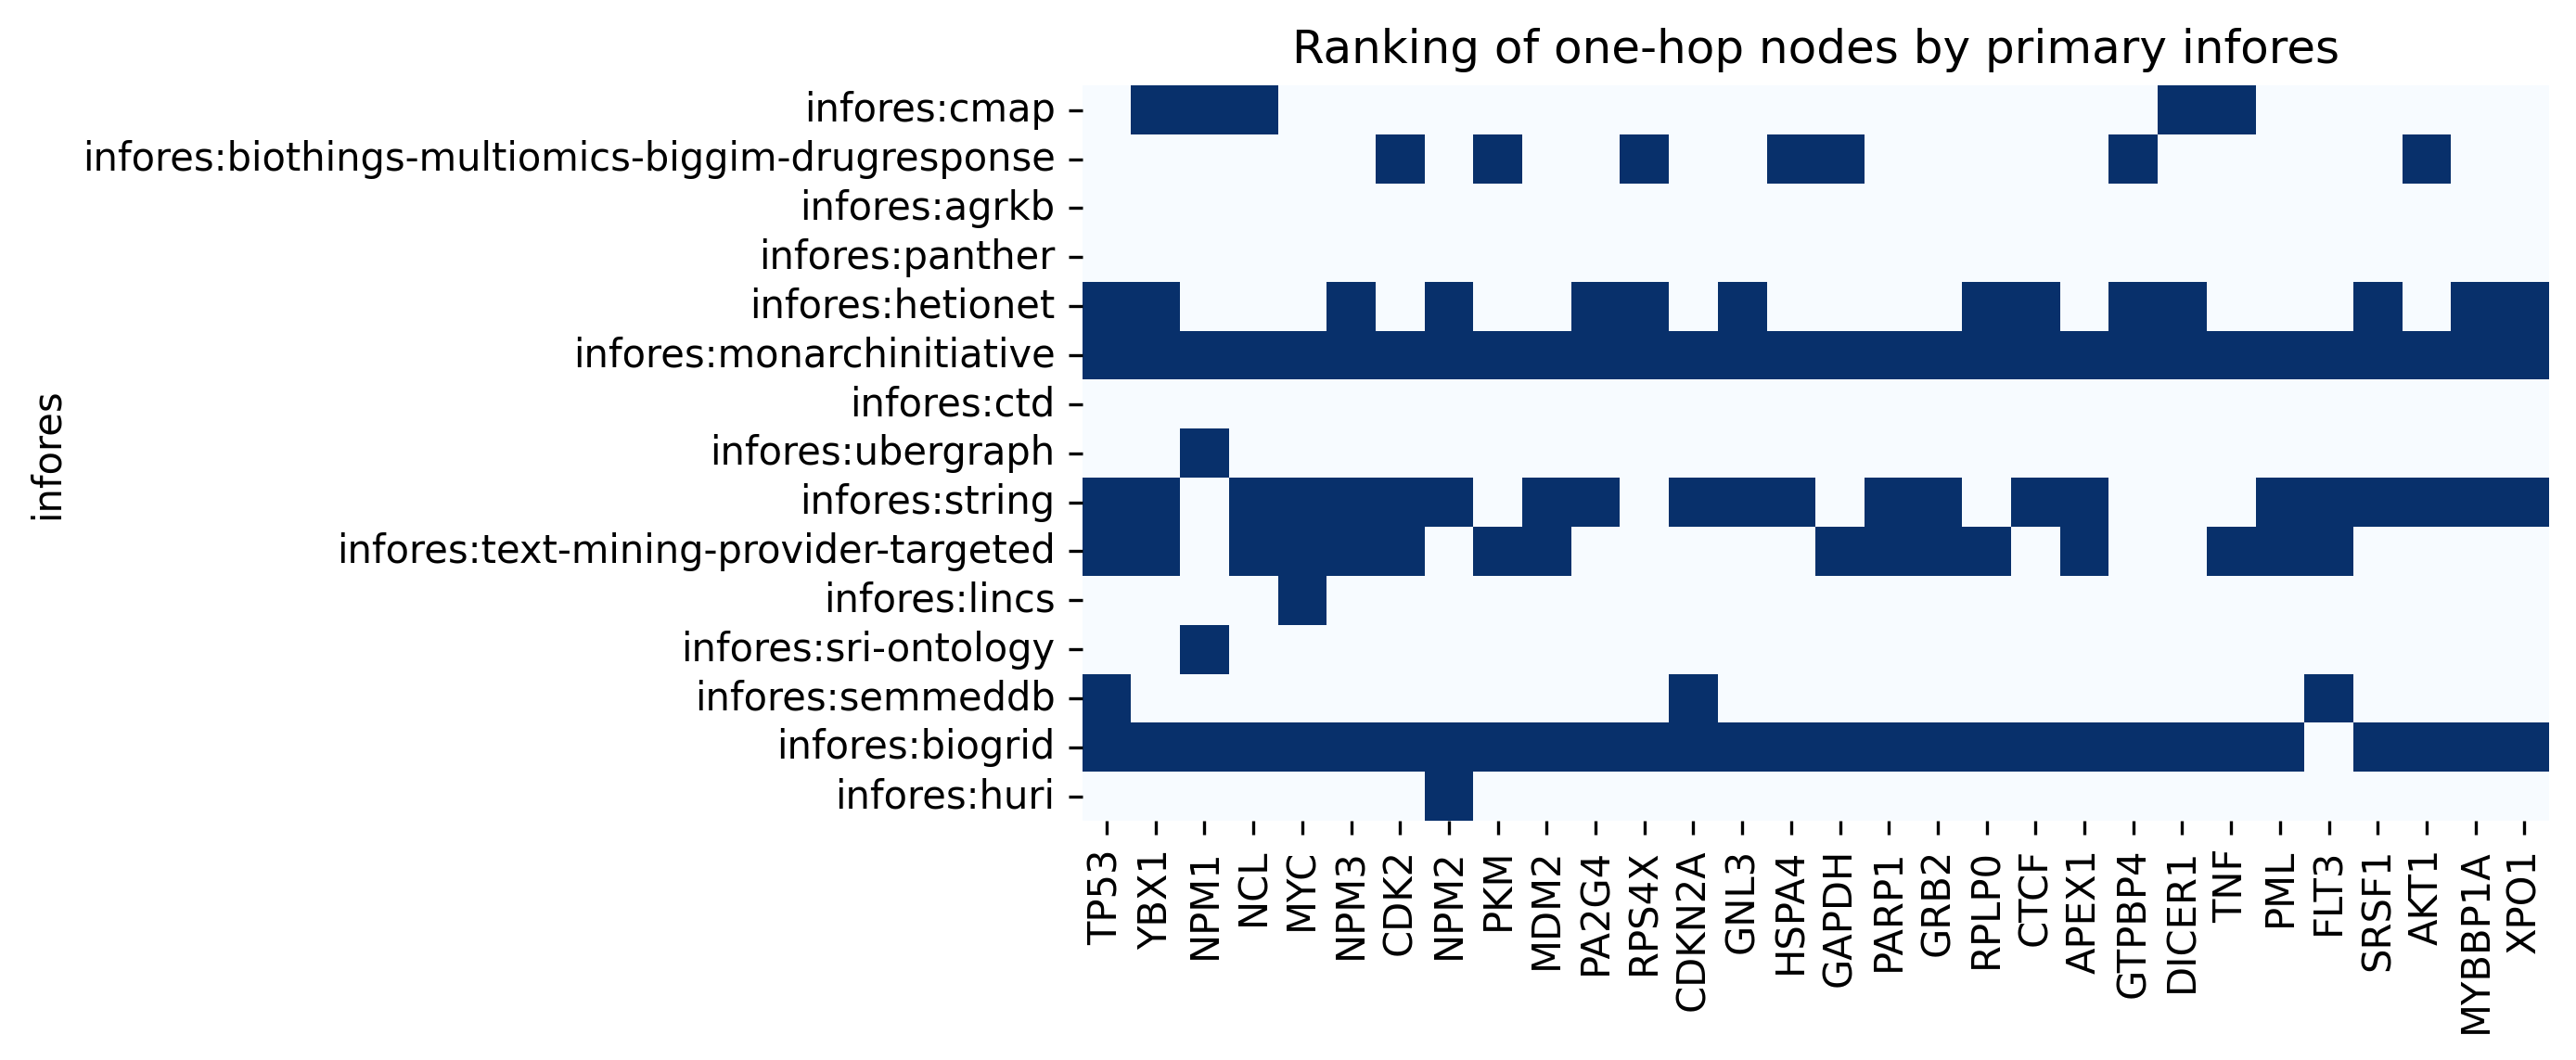

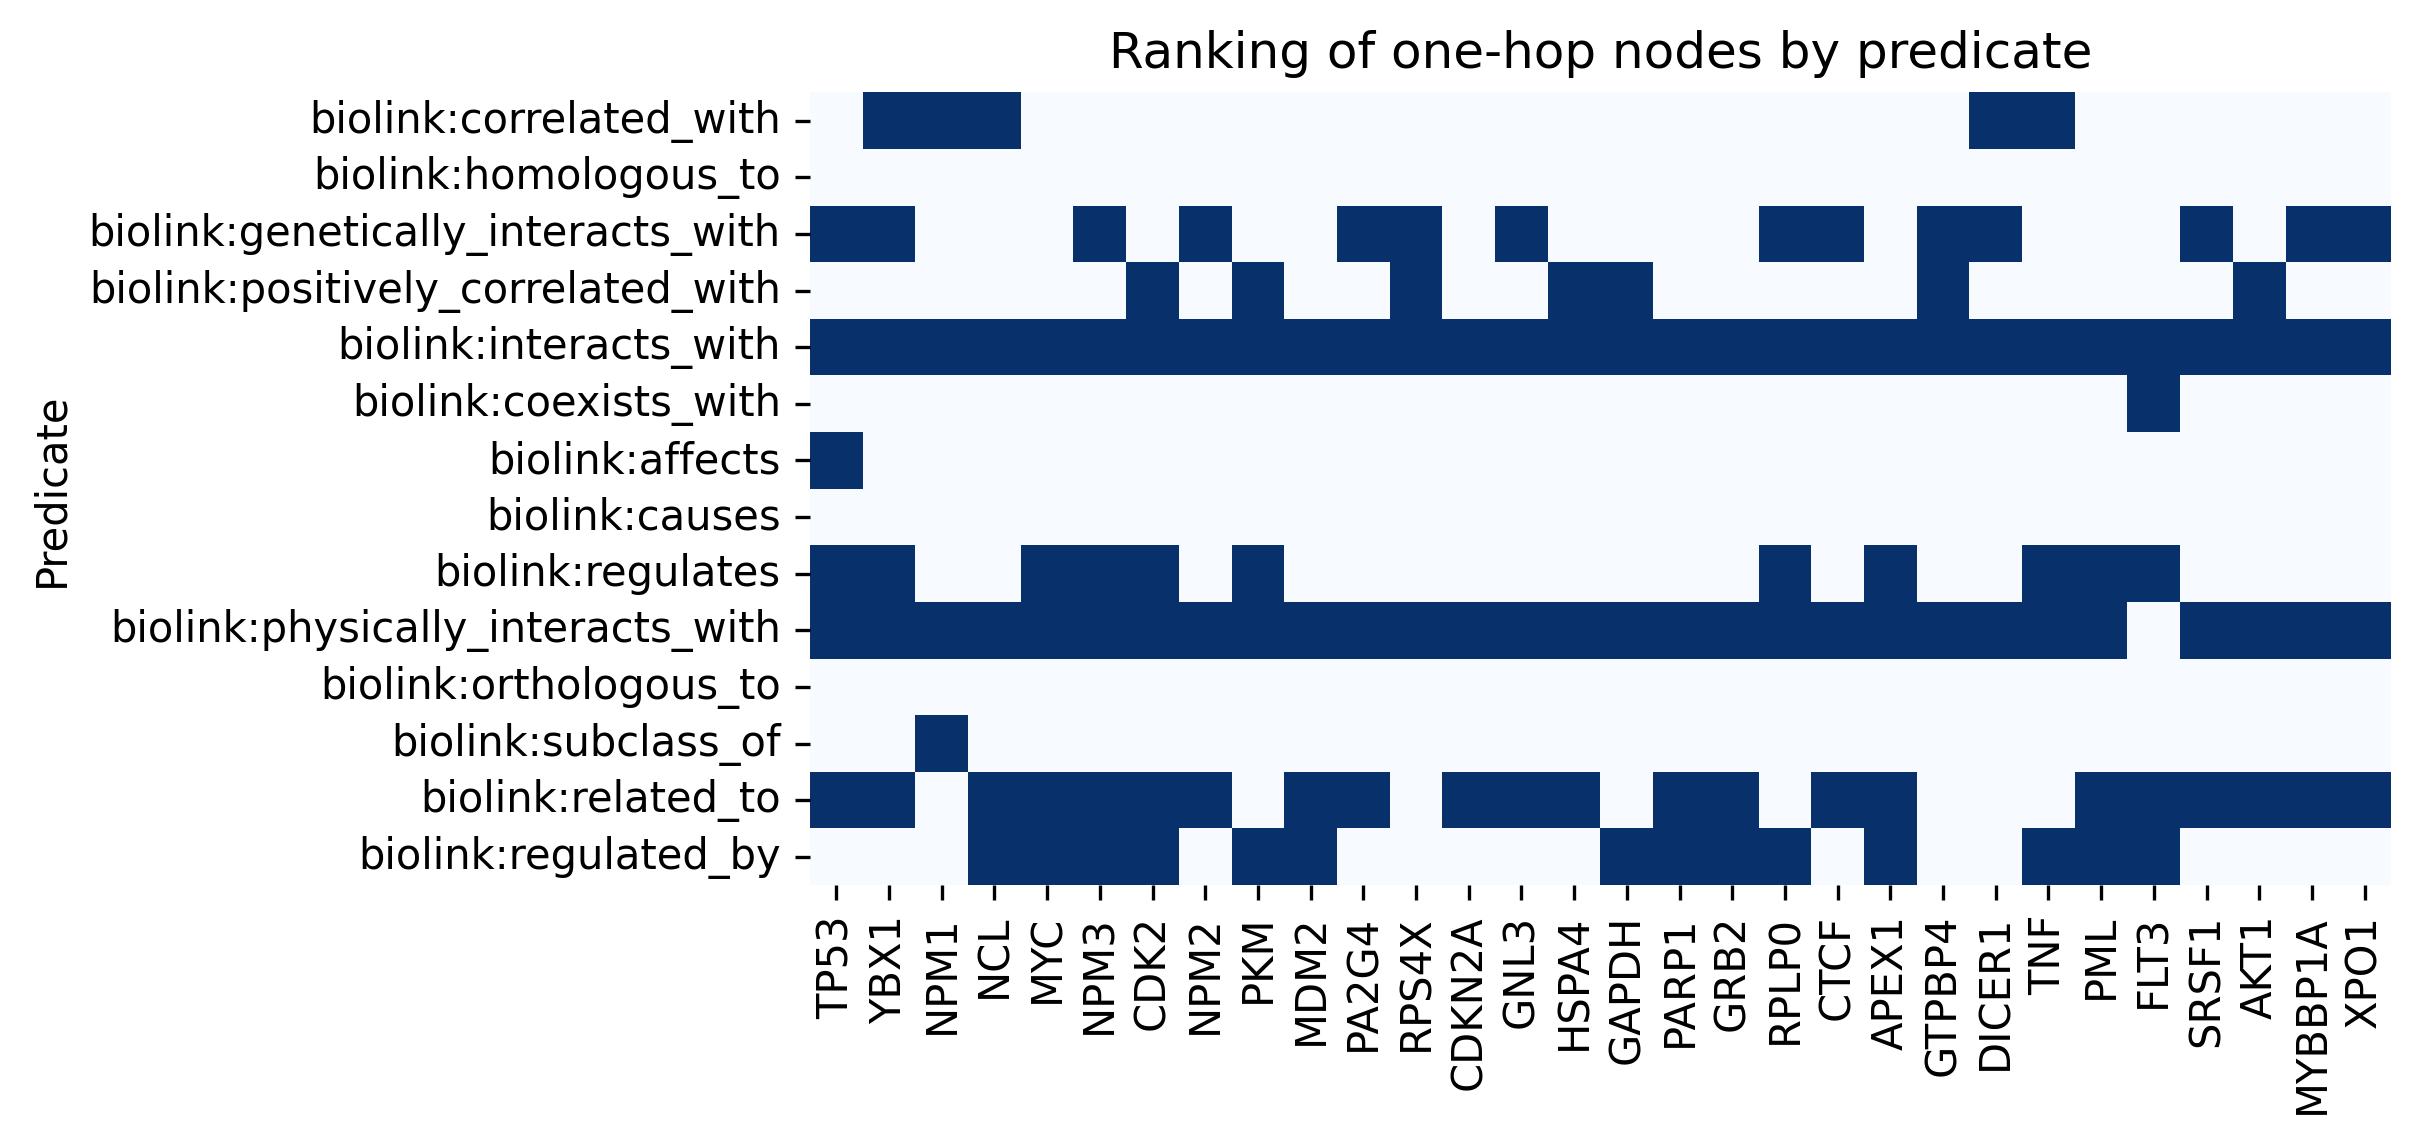

In [6]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, 
                                num_of_nodes = 30, input_query = input_node1_id, 
                                fontsize = 10)


In [8]:
# End of the example